In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso

In [2]:
!pip install pyarrow

You should consider upgrading via the '/workspaces/mlops/02-experiment-tracking/venv/bin/python3 -m pip install --upgrade pip' command.


In [15]:
def read_dataframe(filename): 
    
    df = pd.read_parquet(filename)
    pd.to_datetime(df.lpep_pickup_datetime)
    pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [16]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')

In [17]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333


In [18]:
len(df_train), len(df_val)

(54373, 51497)

In [24]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)  # fit on training data

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)  # just transform val using the same fitted vectorizer

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

82.99831125693512

In [42]:
from sklearn.metrics import mean_squared_error

with mlflow.start_run():
    mlflow.set_tag("developer", "sakshi")
    alpha = 0.001
    mlflow.log_param('alpha', alpha)
    lr = Lasso()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

/tmp/ipykernel_5718/3515213321.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Predicted')
/tmp/ipykernel_5718/3515213321.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

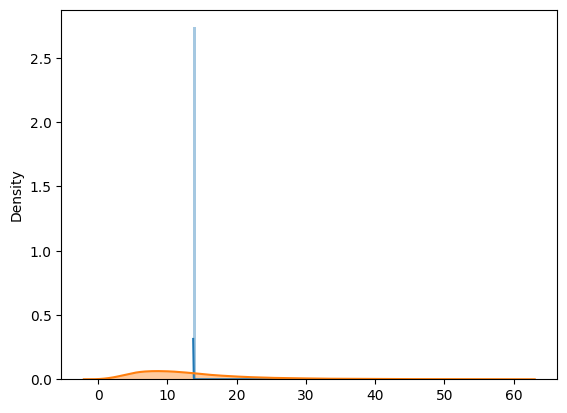

In [43]:
sns.distplot(y_pred, label='Predicted')
sns.distplot(y_train, label='Actual')
plt.legend

In [44]:
import pickle

In [45]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out)

In [46]:
import mlflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('green-taxi-analysis')

<Experiment: artifact_location='/workspaces/mlops/02-experiment-tracking/mlruns/1', creation_time=1751881807135, experiment_id='1', last_update_time=1751881807135, lifecycle_stage='active', name='green-taxi-analysis', tags={}>

In [47]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [48]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [53]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [54]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:6.51713                                                                                
[1]	validation-rmse:5.75605                                                                                
[2]	validation-rmse:5.52998                                                                                
[3]	validation-rmse:5.45366                                                                                
[4]	validation-rmse:5.41808                                                                                
[5]	validation-rmse:5.40169                                                                                
[6]	validation-rmse:5.38446                                                                                
[7]	validation-rmse:5.37990                                                                                
[8]	validation-rmse:5.36940                                                                                
[9]	validation-rmse:5.35854 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:17:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[13]	validation-rmse:5.31932                                                                               
[14]	validation-rmse:5.31129                                                                               
[15]	validation-rmse:5.30880                                                                               
[16]	validation-rmse:5.30125                                                                               
[17]	validation-rmse:5.29748                                                                               
[18]	validation-rmse:5.29141                                                                               
[19]	validation-rmse:5.28913                                                                               
[20]	validation-rmse:5.28723                                                                               
[21]	validation-rmse:5.28204                                                                               
[22]	validation-rmse:5.27500

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:17:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.76456                                                                                
[3]	validation-rmse:7.41576                                                                                
[4]	validation-rmse:7.10882                                                                                
[5]	validation-rmse:6.83831                                                                                
[6]	validation-rmse:6.60219                                                                                
[7]	validation-rmse:6.39787                                                                                
[8]	validation-rmse:6.22321                                                                                
[9]	validation-rmse:6.07000                                                                                
[10]	validation-rmse:5.93629                                                                               
[11]	validation-rmse:5.82289

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:17:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.85898                                                                                
[1]	validation-rmse:5.34629                                                                                
[2]	validation-rmse:5.30734                                                                                
[3]	validation-rmse:5.31598                                                                                
[4]	validation-rmse:5.32303                                                                                
[5]	validation-rmse:5.33003                                                                                
[6]	validation-rmse:5.32864                                                                                
[7]	validation-rmse:5.33606                                                                                
[8]	validation-rmse:5.34234                                                                                
[9]	validation-rmse:5.34080 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:17:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.49467                                                                                
[1]	validation-rmse:6.51053                                                                                
[2]	validation-rmse:5.94478                                                                                
[3]	validation-rmse:5.63273                                                                                
[4]	validation-rmse:5.47563                                                                                
[5]	validation-rmse:5.40612                                                                                
[6]	validation-rmse:5.37433                                                                                
[7]	validation-rmse:5.36683                                                                                
[8]	validation-rmse:5.36843                                                                                
[9]	validation-rmse:5.37899 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:17:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.10995                                                                                
[3]	validation-rmse:6.67758                                                                                
[4]	validation-rmse:6.34183                                                                                
[5]	validation-rmse:6.07094                                                                                
[6]	validation-rmse:5.86448                                                                                
[7]	validation-rmse:5.70360                                                                                
[8]	validation-rmse:5.57695                                                                                
[9]	validation-rmse:5.48011                                                                                
[10]	validation-rmse:5.40946                                                                               
[11]	validation-rmse:5.34916

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:17:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.35472                                                                                
[1]	validation-rmse:6.35035                                                                                
[2]	validation-rmse:5.81252                                                                                
[3]	validation-rmse:5.54976                                                                                
[4]	validation-rmse:5.43348                                                                                
[5]	validation-rmse:5.38601                                                                                
[6]	validation-rmse:5.37761                                                                                
[7]	validation-rmse:5.37967                                                                                
[8]	validation-rmse:5.38839                                                                                
[9]	validation-rmse:5.40321 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:17:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.45246                                                                                
[2]	validation-rmse:8.16061                                                                                
[3]	validation-rmse:7.89194                                                                                
[4]	validation-rmse:7.64339                                                                                
[5]	validation-rmse:7.41577                                                                                
[6]	validation-rmse:7.20659                                                                                
[7]	validation-rmse:7.01446                                                                                
[8]	validation-rmse:6.83816                                                                                
[9]	validation-rmse:6.67787                                                                                
[10]	validation-rmse:6.53162

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:17:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.11429                                                                                
[1]	validation-rmse:5.48458                                                                                
[2]	validation-rmse:5.42345                                                                                
[3]	validation-rmse:5.44177                                                                                
[4]	validation-rmse:5.46861                                                                                
[5]	validation-rmse:5.47568                                                                                
[6]	validation-rmse:5.48885                                                                                
[7]	validation-rmse:5.49178                                                                                
[8]	validation-rmse:5.50784                                                                                
[9]	validation-rmse:5.51744 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:17:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.17974                                                                                
[7]	validation-rmse:5.15824                                                                                
[8]	validation-rmse:5.14611                                                                                
[9]	validation-rmse:5.13313                                                                                
[10]	validation-rmse:5.12677                                                                               
[11]	validation-rmse:5.12134                                                                               
[12]	validation-rmse:5.11662                                                                               
[13]	validation-rmse:5.11197                                                                               
[14]	validation-rmse:5.10874                                                                               
[15]	validation-rmse:5.10730

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:18:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.85014                                                                                
[2]	validation-rmse:7.36272                                                                                
[3]	validation-rmse:6.95714                                                                                
[4]	validation-rmse:6.61944                                                                                
[5]	validation-rmse:6.34056                                                                                
[6]	validation-rmse:6.11186                                                                                
[7]	validation-rmse:5.92807                                                                                
[8]	validation-rmse:5.77418                                                                                
[9]	validation-rmse:5.65182                                                                                
[10]	validation-rmse:5.55096

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:18:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.86993                                                                                
[1]	validation-rmse:6.99607                                                                                
[2]	validation-rmse:6.40363                                                                                
[3]	validation-rmse:6.00935                                                                                
[4]	validation-rmse:5.75810                                                                                
[5]	validation-rmse:5.59363                                                                                
[6]	validation-rmse:5.49062                                                                                
[7]	validation-rmse:5.42368                                                                                
[8]	validation-rmse:5.38473                                                                                
[9]	validation-rmse:5.36590 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:18:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.07719                                                                                
[3]	validation-rmse:6.64931                                                                                
[4]	validation-rmse:6.32319                                                                                
[5]	validation-rmse:6.06066                                                                                
[6]	validation-rmse:5.85586                                                                                
[7]	validation-rmse:5.70333                                                                                
[8]	validation-rmse:5.58568                                                                                
[9]	validation-rmse:5.49574                                                                                
[10]	validation-rmse:5.43080                                                                               
[11]	validation-rmse:5.37635

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:18:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.85937                                                                                
[2]	validation-rmse:5.44180                                                                                
[3]	validation-rmse:5.27921                                                                                
[4]	validation-rmse:5.22564                                                                                
[5]	validation-rmse:5.20465                                                                                
[6]	validation-rmse:5.19856                                                                                
[7]	validation-rmse:5.19355                                                                                
[8]	validation-rmse:5.19431                                                                                
[9]	validation-rmse:5.19338                                                                                
[10]	validation-rmse:5.18756

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:18:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.23666                                                                                
[3]	validation-rmse:5.20135                                                                                
[4]	validation-rmse:5.19687                                                                                
[5]	validation-rmse:5.19118                                                                                
[6]	validation-rmse:5.18518                                                                                
[7]	validation-rmse:5.18189                                                                                
[8]	validation-rmse:5.18299                                                                                
[9]	validation-rmse:5.18409                                                                                
[10]	validation-rmse:5.18132                                                                               
[11]	validation-rmse:5.17947

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:18:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.21112                                                                                
[3]	validation-rmse:5.18538                                                                                
[4]	validation-rmse:5.16534                                                                                
[5]	validation-rmse:5.16952                                                                                
[6]	validation-rmse:5.15977                                                                                
[7]	validation-rmse:5.16140                                                                                
[8]	validation-rmse:5.16196                                                                                
[9]	validation-rmse:5.16874                                                                                
[10]	validation-rmse:5.16842                                                                               
[11]	validation-rmse:5.16527

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:18:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.89082                                                                                
[1]	validation-rmse:5.95203                                                                                
[2]	validation-rmse:5.59085                                                                                
[3]	validation-rmse:5.48173                                                                                
[4]	validation-rmse:5.46636                                                                                
[5]	validation-rmse:5.47238                                                                                
[6]	validation-rmse:5.48512                                                                                
[7]	validation-rmse:5.50007                                                                                
[8]	validation-rmse:5.50946                                                                                
[9]	validation-rmse:5.52258 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:18:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.78873                                                                                
[1]	validation-rmse:8.48952                                                                                
[2]	validation-rmse:8.21304                                                                                
[3]	validation-rmse:7.95673                                                                                
[4]	validation-rmse:7.72026                                                                                
[5]	validation-rmse:7.50145                                                                                
[6]	validation-rmse:7.29885                                                                                
[7]	validation-rmse:7.11425                                                                                
[8]	validation-rmse:6.94372                                                                                
[9]	validation-rmse:6.78711 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:18:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.39689                                                                                
[1]	validation-rmse:5.61061                                                                                
[2]	validation-rmse:5.42814                                                                                
[3]	validation-rmse:5.41725                                                                                
[4]	validation-rmse:5.43586                                                                                
[5]	validation-rmse:5.46214                                                                                
[6]	validation-rmse:5.47519                                                                                
[7]	validation-rmse:5.48593                                                                                
[8]	validation-rmse:5.49687                                                                                
[9]	validation-rmse:5.49887 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.24407                                                                                
[1]	validation-rmse:6.23336                                                                                
[2]	validation-rmse:5.70856                                                                                
[3]	validation-rmse:5.45407                                                                                
[4]	validation-rmse:5.33893                                                                                
[5]	validation-rmse:5.28801                                                                                
[6]	validation-rmse:5.27362                                                                                
[7]	validation-rmse:5.26762                                                                                
[8]	validation-rmse:5.27687                                                                                
[9]	validation-rmse:5.27793 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.93427                                                                                
[3]	validation-rmse:6.49505                                                                                
[4]	validation-rmse:6.16063                                                                                
[5]	validation-rmse:5.90329                                                                                
[6]	validation-rmse:5.70956                                                                                
[7]	validation-rmse:5.56531                                                                                
[8]	validation-rmse:5.45474                                                                                
[9]	validation-rmse:5.37253                                                                                
[10]	validation-rmse:5.31290                                                                               
[11]	validation-rmse:5.26524

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[17]	validation-rmse:5.35554                                                                               
[18]	validation-rmse:5.35412                                                                               
[19]	validation-rmse:5.35006                                                                               
[20]	validation-rmse:5.34530                                                                               
[21]	validation-rmse:5.34298                                                                               
[22]	validation-rmse:5.34238                                                                               
[23]	validation-rmse:5.33861                                                                               
[24]	validation-rmse:5.33643                                                                               
[25]	validation-rmse:5.32957                                                                               
[26]	validation-rmse:5.32726

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:5.31147                                                                               
[19]	validation-rmse:5.30684                                                                               
[20]	validation-rmse:5.30490                                                                               
[21]	validation-rmse:5.30122                                                                               
[22]	validation-rmse:5.29978                                                                               
[23]	validation-rmse:5.29727                                                                               
[24]	validation-rmse:5.29257                                                                               
[25]	validation-rmse:5.29134                                                                               
[26]	validation-rmse:5.29004                                                                               
[27]	validation-rmse:5.27992

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[11]	validation-rmse:5.20525
[12]	validation-rmse:5.20132                                                                               
[13]	validation-rmse:5.20333                                                                               
[14]	validation-rmse:5.19798                                                                               
[15]	validation-rmse:5.20020                                                                               
[16]	validation-rmse:5.20151                                                                               
[17]	validation-rmse:5.19852                                                                               
[18]	validation-rmse:5.20303                                                                               
[19]	validation-rmse:5.20343                                                                               
[20]	validation-rmse:5.20491                                                                               

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.35533                                                                                
[3]	validation-rmse:5.93967                                                                                
[4]	validation-rmse:5.65798                                                                                
[5]	validation-rmse:5.48050                                                                                
[6]	validation-rmse:5.36225                                                                                
[7]	validation-rmse:5.28104                                                                                
[8]	validation-rmse:5.22971                                                                                
[9]	validation-rmse:5.19542                                                                                
[10]	validation-rmse:5.17062                                                                               
[11]	validation-rmse:5.15190

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:5.24924                                                                               
[11]	validation-rmse:5.24414                                                                               
[12]	validation-rmse:5.23541                                                                               
[13]	validation-rmse:5.23328                                                                               
[14]	validation-rmse:5.23025                                                                               
[15]	validation-rmse:5.22587                                                                               
[16]	validation-rmse:5.21906                                                                               
[17]	validation-rmse:5.21410                                                                               
[18]	validation-rmse:5.20388                                                                               
[19]	validation-rmse:5.20128

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[11]	validation-rmse:5.15362                                                                               
[12]	validation-rmse:5.15037                                                                               
[13]	validation-rmse:5.13854                                                                               
[14]	validation-rmse:5.13596                                                                               
[15]	validation-rmse:5.12787                                                                               
[16]	validation-rmse:5.12479                                                                               
[17]	validation-rmse:5.12191                                                                               
[18]	validation-rmse:5.11755                                                                               
[19]	validation-rmse:5.11720                                                                               
[20]	validation-rmse:5.11473

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.78396                                                                                
[4]	validation-rmse:5.54661                                                                                
[5]	validation-rmse:5.40204                                                                                
[6]	validation-rmse:5.31438                                                                                
[7]	validation-rmse:5.25657                                                                                
[8]	validation-rmse:5.21736                                                                                
[9]	validation-rmse:5.19043                                                                                
[10]	validation-rmse:5.17451                                                                               
[11]	validation-rmse:5.16088                                                                               
[12]	validation-rmse:5.15033

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.78550                                                                                
[4]	validation-rmse:5.54983                                                                                
[5]	validation-rmse:5.40438                                                                                
[6]	validation-rmse:5.31452                                                                                
[7]	validation-rmse:5.25468                                                                                
[8]	validation-rmse:5.21861                                                                                
[9]	validation-rmse:5.19407                                                                                
[10]	validation-rmse:5.17806                                                                               
[11]	validation-rmse:5.16438                                                                               
[12]	validation-rmse:5.15468

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.56749                                                                                
[7]	validation-rmse:5.46639                                                                                
[8]	validation-rmse:5.39286                                                                                
[9]	validation-rmse:5.33926                                                                                
[10]	validation-rmse:5.30076                                                                               
[11]	validation-rmse:5.27165                                                                               
[12]	validation-rmse:5.25118                                                                               
[13]	validation-rmse:5.23431                                                                               
[14]	validation-rmse:5.22056                                                                               
[15]	validation-rmse:5.20949

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:5.73226                                                                                
[6]	validation-rmse:5.56908                                                                                
[7]	validation-rmse:5.45518                                                                                
[8]	validation-rmse:5.37317                                                                                
[9]	validation-rmse:5.31677                                                                                
[10]	validation-rmse:5.27055                                                                               
[11]	validation-rmse:5.23918                                                                               
[12]	validation-rmse:5.21684                                                                               
[13]	validation-rmse:5.19748                                                                               
[14]	validation-rmse:5.18367

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.91572                                                                                
[3]	validation-rmse:7.59496                                                                                
[4]	validation-rmse:7.30645                                                                                
[5]	validation-rmse:7.05033                                                                                
[6]	validation-rmse:6.81837                                                                                
[7]	validation-rmse:6.61478                                                                                
[8]	validation-rmse:6.43278                                                                                
[9]	validation-rmse:6.27321                                                                                
[10]	validation-rmse:6.13334                                                                               
[11]	validation-rmse:6.00776

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.23213                                                                                
[4]	validation-rmse:5.91733                                                                                
[5]	validation-rmse:5.69105                                                                                
[6]	validation-rmse:5.52649                                                                                
[7]	validation-rmse:5.41276                                                                                
[8]	validation-rmse:5.33286                                                                                
[9]	validation-rmse:5.27406                                                                                
[10]	validation-rmse:5.23274                                                                               
[11]	validation-rmse:5.20243                                                                               
[12]	validation-rmse:5.18180

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:5.80385                                                                               
[11]	validation-rmse:5.71221                                                                               
[12]	validation-rmse:5.63291                                                                               
[13]	validation-rmse:5.56859                                                                               
[14]	validation-rmse:5.51469                                                                               
[15]	validation-rmse:5.47146                                                                               
[16]	validation-rmse:5.43546                                                                               
[17]	validation-rmse:5.40282                                                                               
[18]	validation-rmse:5.37567                                                                               
[19]	validation-rmse:5.35054

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:6.22785                                                                                
[8]	validation-rmse:6.06590                                                                                
[9]	validation-rmse:5.92989                                                                                
[10]	validation-rmse:5.81607                                                                               
[11]	validation-rmse:5.71878                                                                               
[12]	validation-rmse:5.63712                                                                               
[13]	validation-rmse:5.56936                                                                               
[14]	validation-rmse:5.51251                                                                               
[15]	validation-rmse:5.46443                                                                               
[16]	validation-rmse:5.42118

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.66334                                                                                
[1]	validation-rmse:8.26075                                                                                
[2]	validation-rmse:7.90114                                                                                
[3]	validation-rmse:7.58012                                                                                
[4]	validation-rmse:7.29393                                                                                
[5]	validation-rmse:7.04134                                                                                
[6]	validation-rmse:6.81743                                                                                
[7]	validation-rmse:6.61990                                                                                
[8]	validation-rmse:6.44705                                                                                
[9]	validation-rmse:6.29405 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:6.17955                                                                                
[8]	validation-rmse:6.02278                                                                                
[9]	validation-rmse:5.89060                                                                                
[10]	validation-rmse:5.77897                                                                               
[11]	validation-rmse:5.68725                                                                               
[12]	validation-rmse:5.60892                                                                               
[13]	validation-rmse:5.54338                                                                               
[14]	validation-rmse:5.49243                                                                               
[15]	validation-rmse:5.44859                                                                               
[16]	validation-rmse:5.40881

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[13]	validation-rmse:6.25573                                                                               
[14]	validation-rmse:6.16375                                                                               
[15]	validation-rmse:6.08007                                                                               
[16]	validation-rmse:6.00355                                                                               
[17]	validation-rmse:5.93437                                                                               
[18]	validation-rmse:5.87262                                                                               
[19]	validation-rmse:5.81626                                                                               
[20]	validation-rmse:5.76722                                                                               
[21]	validation-rmse:5.72214                                                                               
[22]	validation-rmse:5.68077

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.73131                                                                                
[1]	validation-rmse:8.38209                                                                                
[2]	validation-rmse:8.06474                                                                                
[3]	validation-rmse:7.77347                                                                                
[4]	validation-rmse:7.50979                                                                                
[5]	validation-rmse:7.27055                                                                                
[6]	validation-rmse:7.05188                                                                                
[7]	validation-rmse:6.85535                                                                                
[8]	validation-rmse:6.67721                                                                                
[9]	validation-rmse:6.51862 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.10502                                                                                
[5]	validation-rmse:6.84006                                                                                
[6]	validation-rmse:6.60651                                                                                
[7]	validation-rmse:6.40567                                                                                
[8]	validation-rmse:6.22794                                                                                
[9]	validation-rmse:6.07617                                                                                
[10]	validation-rmse:5.94551                                                                               
[11]	validation-rmse:5.83399                                                                               
[12]	validation-rmse:5.73630                                                                               
[13]	validation-rmse:5.65391

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.37009                                                                                
[1]	validation-rmse:7.75751                                                                                
[2]	validation-rmse:7.26134                                                                                
[3]	validation-rmse:6.85629                                                                                
[4]	validation-rmse:6.53221                                                                                
[5]	validation-rmse:6.27744                                                                                
[6]	validation-rmse:6.07589                                                                                
[7]	validation-rmse:5.91527                                                                                
[8]	validation-rmse:5.79320                                                                                
[9]	validation-rmse:5.69692 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[16]	validation-rmse:6.06818
[17]	validation-rmse:6.00467                                                                               
[18]	validation-rmse:5.94672                                                                               
[19]	validation-rmse:5.89344                                                                               
[20]	validation-rmse:5.84656                                                                               
[21]	validation-rmse:5.80478                                                                               
[22]	validation-rmse:5.76554                                                                               
[23]	validation-rmse:5.73097                                                                               
[24]	validation-rmse:5.69910                                                                               
[25]	validation-rmse:5.66910                                                                               

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.72595                                                                                
[3]	validation-rmse:7.37435                                                                                
[4]	validation-rmse:7.06158                                                                                
[5]	validation-rmse:6.79353                                                                                
[6]	validation-rmse:6.55981                                                                                
[7]	validation-rmse:6.35513                                                                                
[8]	validation-rmse:6.18119                                                                                
[9]	validation-rmse:6.02901                                                                                
[10]	validation-rmse:5.90062                                                                               
[11]	validation-rmse:5.78865

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.61892                                                                                
[4]	validation-rmse:7.33950                                                                                
[5]	validation-rmse:7.08670                                                                                
[6]	validation-rmse:6.86196                                                                                
[7]	validation-rmse:6.66538                                                                                
[8]	validation-rmse:6.48904                                                                                
[9]	validation-rmse:6.33099                                                                                
[10]	validation-rmse:6.19340                                                                               
[11]	validation-rmse:6.07250                                                                               
[12]	validation-rmse:5.96551

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.50616                                                                                
[2]	validation-rmse:8.23415                                                                                
[3]	validation-rmse:7.98209                                                                                
[4]	validation-rmse:7.74779                                                                                
[5]	validation-rmse:7.53069                                                                                
[6]	validation-rmse:7.33102                                                                                
[7]	validation-rmse:7.14685                                                                                
[8]	validation-rmse:6.97811                                                                                
[9]	validation-rmse:6.82162                                                                                
[10]	validation-rmse:6.67893

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.70494                                                                                
[2]	validation-rmse:7.18473                                                                                
[3]	validation-rmse:6.75715                                                                                
[4]	validation-rmse:6.41614                                                                                
[5]	validation-rmse:6.14400                                                                                
[6]	validation-rmse:5.92728                                                                                
[7]	validation-rmse:5.76099                                                                                
[8]	validation-rmse:5.62933                                                                                
[9]	validation-rmse:5.53039                                                                                
[10]	validation-rmse:5.45563

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.16101                                                                                
[1]	validation-rmse:7.42199                                                                                
[2]	validation-rmse:6.85337                                                                                
[3]	validation-rmse:6.42667                                                                                
[4]	validation-rmse:6.11158                                                                                
[5]	validation-rmse:5.87425                                                                                
[6]	validation-rmse:5.70265                                                                                
[7]	validation-rmse:5.58388                                                                                
[8]	validation-rmse:5.49747                                                                                
[9]	validation-rmse:5.43230 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:22:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.50578                                                                                
[1]	validation-rmse:7.98746                                                                                
[2]	validation-rmse:7.54468                                                                                
[3]	validation-rmse:7.17474                                                                                
[4]	validation-rmse:6.86565                                                                                
[5]	validation-rmse:6.60859                                                                                
[6]	validation-rmse:6.39319                                                                                
[7]	validation-rmse:6.21788                                                                                
[8]	validation-rmse:6.07259                                                                                
[9]	validation-rmse:5.95492 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:22:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.75188                                                                                
[1]	validation-rmse:8.42047                                                                                
[2]	validation-rmse:8.11803                                                                                
[3]	validation-rmse:7.84337                                                                                
[4]	validation-rmse:7.59170                                                                                
[5]	validation-rmse:7.36502                                                                                
[6]	validation-rmse:7.15745                                                                                
[7]	validation-rmse:6.97030                                                                                
[8]	validation-rmse:6.79696                                                                                
[9]	validation-rmse:6.64532 

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:22:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[13]	validation-rmse:5.50427                                                                               
[14]	validation-rmse:5.46497                                                                               
[15]	validation-rmse:5.43150                                                                               
[16]	validation-rmse:5.39955                                                                               
[17]	validation-rmse:5.37512                                                                               
[18]	validation-rmse:5.35388                                                                               
[19]	validation-rmse:5.33743                                                                               
[20]	validation-rmse:5.32156                                                                               
[21]	validation-rmse:5.30898                                                                               
[22]	validation-rmse:5.29883

/workspaces/mlops/02-experiment-tracking/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:22:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.43374                                                                                
[5]	validation-rmse:7.18872                                                                                
[6]	validation-rmse:6.96505                                                                                
[7]	validation-rmse:6.76862                                                                                
[8]	validation-rmse:6.59046                                                                                
[9]	validation-rmse:6.43151                                                                                
[10]	validation-rmse:6.28856                                                                               
[11]	validation-rmse:6.16013                                                                               
[12]	validation-rmse:6.04373                                                                               
[13]	validation-rmse:5.94252

In [ ]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)